# Draft workbook to test plotting functions

Plots to do:
- Basic TS plot
- Seasonal plot + polar!
- Seasonal subseries plot (also box?)
- Scatterplot
- ACF plots

## Imports and setups

In [4]:
import sys
sys.path.append('../')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

from gtime.preprocessing import TimeSeriesPreparation
from gtime.compose import FeatureCreation
from gtime.time_series_models import (
    NaiveForecastModel, 
    SeasonalNaiveForecastModel, 
    AverageForecastModel, 
    DriftForecastModel,
)

## Ploting functions

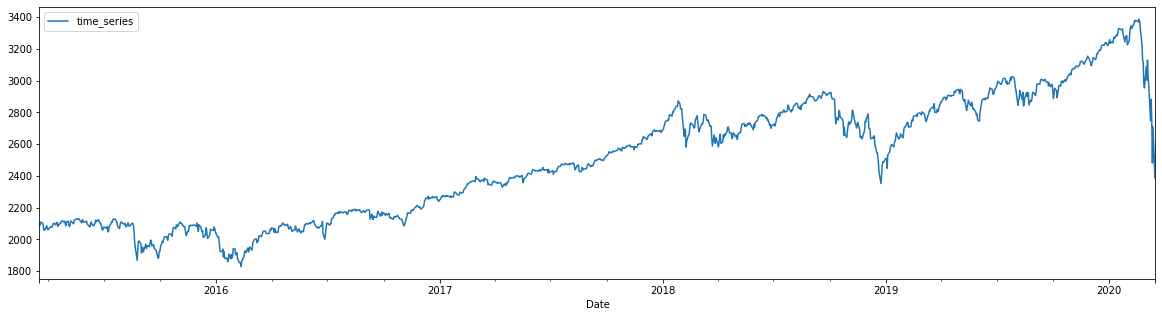

In [574]:
df_sp = pd.read_csv('data/^GSPC.csv')
df_close = df_sp.set_index('Date')['Close']
df_close.index = pd.to_datetime(df_close.index)
time_series_preparation = TimeSeriesPreparation()
period_index_time_series = time_series_preparation.transform(df_close)
period_index_time_series.plot(figsize=(20, 5))
plt.show()

## Time series setup

In [558]:
def autocorr(x, lag):
    x_lag = x[lag:]
    x_1 = x[:-lag]
    cov = np.cov(x_1, x_lag)
    print(cov)
    corr = cov[0, 1] / np.sqrt(cov[1, 1] * cov[0, 0])
    return corr

autocorr(np.array([1, 2, 1, 4]), 1)

[[ 0.33333333 -0.66666667]
 [-0.66666667  2.33333333]]


-0.7559289460184544

In [567]:
autocorr(period_index_time_series.values.squeeze(), 4)

[[21386.30227315 20061.02436729]
 [20061.02436729 20365.8715986 ]]


0.9612442487106876

In [566]:
acf(period_index_time_series, 10)

,time_series
1,0.988798
2,0.979353
3,0.970506
4,0.961244
5,0.951605
6,0.943326
7,0.936893
8,0.926351
9,0.915691
10,0.902580


In [515]:
def acf(df, max_lag=10):
    s = pd.DataFrame(np.nan, index=range(1, max_lag + 1), columns=df.columns)
    for i, col in df.iteritems():
        for j in s.index:
            s.loc[j, i] = col.autocorr(j)
    return s
            

In [512]:
# helper functions

def seasonal_split(df : pd.DataFrame, season):
    
    df = df.copy()
    
    if isinstance(season, str):
        if season == 'year':
            df['Period'] = ''
            df['Season'] = df.index.year
            df['Idx'] = df.index.dayofyear
        elif season == 'month':
            df['Period'] = df.index.year
            df['Season'] = df.index.month
#             df['Season_name'] = list(map(lambda x: '_'.join([str(x.year), str(x.month)]), df.index))
            df['Idx'] = df.index.day
        elif season == 'week':
            df['Period'] = df.index.year
            df['Season'] = df.index.week
#             df['Season_name'] = list(map(lambda x: '_'.join([str(x.year), str(x.weekofyear)]), df.index))
            df['Idx'] = df.index.dayofweek
        else:
            raise ValueError("Incorrect period name")
            
        return df.set_index(['Period', 'Season', 'Idx']).unstack(level=[0, 1])
            
    elif isinstance(season, pd.Timedelta):
        cols = []
        series = []
        for i, col in ddf.resample(season):
            cols.append(i)
            series.append(col.reset_index(drop=True))
        return pd.concat(series, keys=cols, axis=1)
    
seasonal_split(period_index_time_series, 'week')

time_series                                                      \
Period         2019                                                       
Season           1            2            3            4            5    
Idx                                                                       
0       3221.290039  2549.689941  2582.610107          NaN  2643.850098   
1       3230.780029  2574.409912  2610.300049  2632.899902  2640.000000   
2       2510.030029  2584.959961  2616.100098  2638.699951  2681.050049   
3       2447.889893  2596.639893  2635.959961  2642.330078  2704.100098   
4       2531.939941  2596.260010  2670.709961  2664.760010  2706.530029   

                                                                         ...  \
Period                                                                   ...   
Season           6            7            8            9            10  ...   
Idx                                                                      ...   
0       2724.870117  2709.800049          NaN  2796.110107  2792.810059  ...   
1       2737.699951  2744.729980  2779.760010  2793.899902  2789.649902  ...   
2       2731.610107  2753.030029  2784.699951  2792.379883  2771.449951  ...   
3       2706.050049  2745.729980  2774.879883  2784.489990  2748.929932  ...   
4       2707.879883  2775.600098  2792.669922  2803.689941  2743.070068  ...   

                                                                         \
Period                                                                    
Season           43           44           45           46           47   
Idx                                                                       
0       3006.719971  3039.419922  3078.270020  3087.010010  3122.030029   
1       2995.989990  3036.889893  3074.620117  3091.840088  3120.179932   
2       3004.520020  3046.770020  3076.780029  3094.040039  3108.459961   
3       3010.290039  3037.560059  3085.179932  3096.629883  3103.540039   
4       3022.550049  3066.909912  3093.080078  3120.459961  3110.290039   

                                                                         
Period                                                                   
Season           48           49           50           51           52  
Idx                                                                      
0       3133.639893  3113.870117  3135.959961  3191.449951  3224.010010  
1       3140.520020  3093.199951  3132.520020  3192.520020  3223.379883  
2       3153.629883  3112.760010  3141.629883  3191.139893          NaN  
3               NaN  3117.429932  3168.570068  3205.370117  3239.909912  
4       3140.979980  3145.909912  3168.800049  3221.219971  3240.020020  

[5 rows x 52 columns]

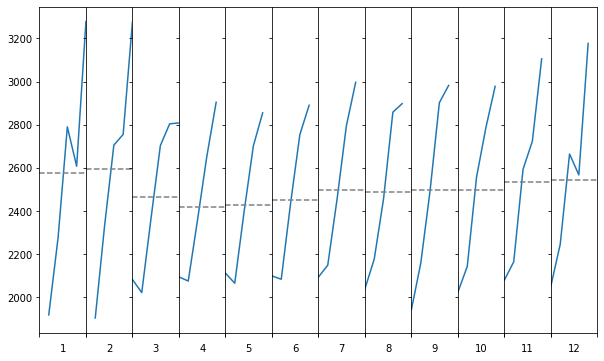

In [714]:
def subplot_split(df: pd.DataFrame, season, agg):
    res = seasonal_split(df, season)
    res = res.agg(agg, axis=0).unstack()
    return res



def subplots(df: pd.DataFrame, season, agg):
    ss = subplot_split(df, season, agg)
    fig, ax = plt.subplots(ss.index.levshape[0], ss.shape[1], 
                           sharey=True, figsize=(10, 6), squeeze=False, 
                           gridspec_kw={'wspace':0})
    i = 0
    for _, table in ss.groupby(level=0):
        j = 0
        for _, col in table.iteritems():
            axes = ax[i, j]
            col.plot(ax=axes)
            mean = col.mean()
            axes.axhline(mean, color='gray', linestyle='--')
            axes.set(xlabel=col.name)
            axes.set_xticklabels([])
            j += 1
        i += 1
    plt.show()

subplots(period_index_time_series, 'month', 'mean')    
    

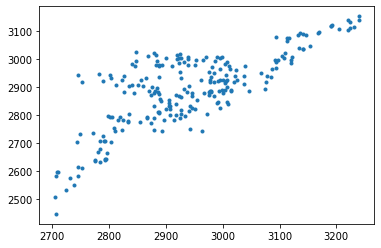

In [486]:
plt.plot(period_index_time_series, period_index_time_series.shift(20), '.')

In [507]:
seasonal_split(period_index_time_series, 'month')

time_series                                                      \
Season_name       2019_1      2019_10      2019_11      2019_12       2019_2   
Idx                                                                            
1                    NaN  2940.250000  3066.909912          NaN  2706.530029   
2            2510.030029  2887.610107          NaN  3113.870117          NaN   
3            2447.889893  2910.629883          NaN  3093.199951          NaN   
4            2531.939941  2952.010010  3078.270020  3112.760010  2724.870117   
5                    NaN          NaN  3074.620117  3117.429932  2737.699951   
6                    NaN          NaN  3076.780029  3145.909912  2731.610107   
7            2549.689941  2938.790039  3085.179932          NaN  2706.050049   
8            2574.409912  2893.060059  3093.080078          NaN  2707.879883   
9            2584.959961  2919.399902          NaN  3135.959961          NaN   
10           2596.639893  2938.129883          NaN  3132.520020          NaN   
11           2596.260010  2970.270020  3087.010010  3141.629883  2709.800049   
12                   NaN          NaN  3091.840088  3168.570068  2744.729980   
13                   NaN          NaN  3094.040039  3168.800049  2753.030029   
14           2582.610107  2966.149902  3096.629883          NaN  2745.729980   
15           2610.300049  2995.679932  3120.459961          NaN  2775.600098   
16           2616.100098  2989.689941          NaN  3191.449951          NaN   
17           2635.959961  2997.949951          NaN  3192.520020          NaN   
18           2670.709961  2986.199951  3122.030029  3191.139893          NaN   
19                   NaN          NaN  3120.179932  3205.370117  2779.760010   
20                   NaN          NaN  3108.459961  3221.219971  2784.699951   
21                   NaN  3006.719971  3103.540039          NaN  2774.879883   
22           2632.899902  2995.989990  3110.290039          NaN  2792.669922   
23           2638.699951  3004.520020          NaN  3224.010010          NaN   
24           2642.330078  3010.290039          NaN  3223.379883          NaN   
25           2664.760010  3022.550049  3133.639893          NaN  2796.110107   
26                   NaN          NaN  3140.520020  3239.909912  2793.899902   
27                   NaN          NaN  3153.629883  3240.020020  2792.379883   
28           2643.850098  3039.419922          NaN          NaN  2784.489990   
29           2640.000000  3036.889893  3140.979980          NaN          NaN   
30           2681.050049  3046.770020          NaN  3221.290039          NaN   
31           2704.100098  3037.560059          NaN  3230.780029          NaN   

                                                                              \
Season_name       2019_3       2019_4       2019_5       2019_6       2019_7   
Idx                                                                            
1            2803.689941  2867.189941  2923.729980          NaN  2964.330078   
2                    NaN  2867.239990  2917.520020          NaN  2973.010010   
3                    NaN  2873.399902  2945.639893  2744.449951  2995.820068   
4            2792.810059  2879.389893          NaN  2803.270020          NaN   
5            2789.649902  2892.739990          NaN  2826.149902  2990.409912   
6            2771.449951          NaN  2932.469971  2843.489990          NaN   
7            2748.929932          NaN  2884.050049  2873.340088          NaN   
8            2743.070068  2895.770020  2879.419922          NaN  2975.949951   
9                    NaN  2878.199951  2870.719971          NaN  2979.629883   
10                   NaN  2888.209961  2881.399902  2886.729980  2993.070068   
11           2783.300049  2888.320068          NaN  2885.719971  2999.909912   
12           2791.520020  2907.409912          NaN  2879.840088  3013.770020   
13           2810.919922          NaN  2811.870117  2891.639893          NaN   
14          

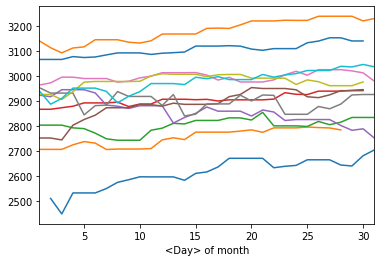

In [513]:
def plot_fun(df, ax=None):
    if ax is None:
        ax = df.plot(legend=False)
    else:
        df.plot(ax=ax, legend=False)
    return ax

def basic_ts(df, ax=None):
    ax = plot_fun(df, ax)
    return ax

def polar_ts(df, ax=None):
    
    df = df.append(df.iloc[0])
    if ax is None:
        ax = plt.subplot(111, projection='polar')
    angles = [x * 360 / (len(df) - 1) for x in range(len(df))]
    theta = [x / 360 * 2 * np.pi for x in angles]
    for col in df.columns:
        plt.polar(theta, df[col])
    ax.set_thetagrids(angles=angles)
    ax.set_xticklabels(df.index)
    return ax

def season_ts(df: pd.DataFrame, season=None, polar=False, ax=None):
    df_seas = seasonal_split(df, season)
    if polar:
        ax = polar_ts(df_seas, ax=ax)
    else:
        ax = basic_ts(df_seas, ax=ax)
        if isinstance(season, str):
            ax.set_xlabel(str(df.index.freq) + ' of ' + season)
    return ax

season_ts(period_index_time_series.resample('D').first().fillna(method='ffill'), 'month', polar=False)

## Tests

/Users/semyonburyachenko/Documents/Upwork/Giotto/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: M and Y units are deprecated and will be removed in a future version.
  if __name__ == '__main__':
/Users/semyonburyachenko/Documents/Upwork/Giotto/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/semyonburyachenko/Documents/Upwork/Giotto/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/semyonburyachenko/Documents/Upwork/Giotto/venv/lib/python3.7/site-

TypeError: only size-1 arrays can be converted to Python scalars

/Users/semyonburyachenko/Documents/Upwork/Giotto/venv/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


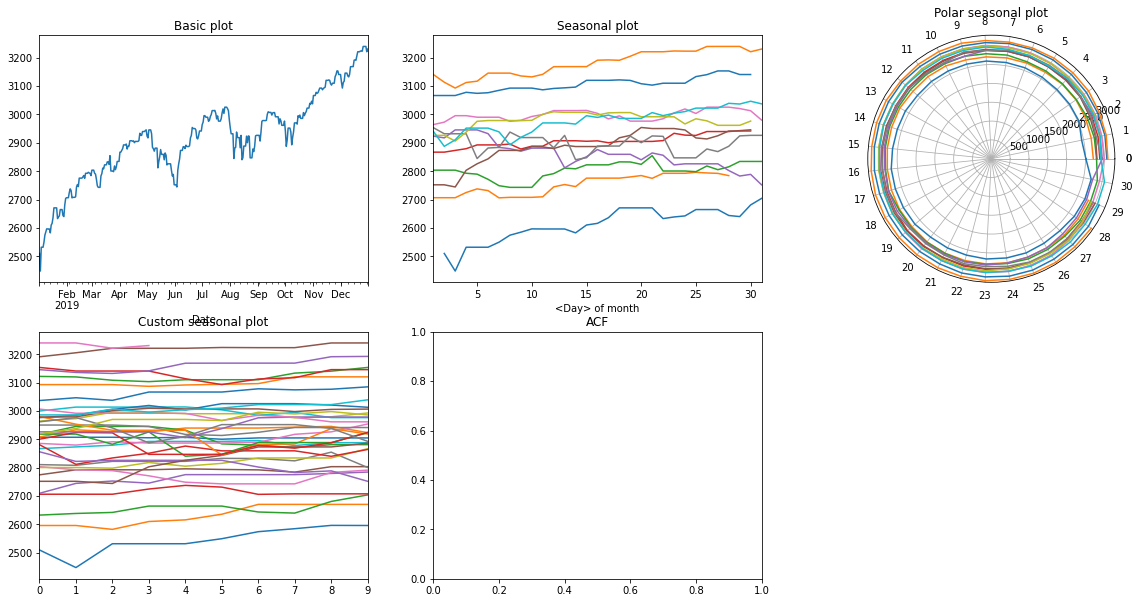

In [514]:
# Show
ddf = period_index_time_series.resample('D').fillna(method='ffill')
fig = plt.figure(figsize=(20, 10))
a = fig.add_subplot(231, title='Basic plot')
basic_ts(ddf, ax=a)
b = fig.add_subplot(232, title='Seasonal plot')
season_ts(ddf, 'month', ax=b)
c = fig.add_subplot(233, projection='polar')
season_ts(ddf, pd.Timedelta(1, 'M'), ax=c, polar=True)
c.set_title('Polar seasonal plot')
d = fig.add_subplot(234, title='Custom seasonal plot')
season_ts(ddf, pd.Timedelta(10, 'D'), ax=d)
e = fig.add_subplot(235, title='ACF')
y = acf(ddf, max_lag=25)
e.bar(y.index, y.values, title='ACF plot')
e = fig.add_subplot(236, title='Lag')
e.plot(ddf, ddf.shift(30), '.')
plt.show()